## Credit Card Fraud Dataset (Kaggle)

### Dataset

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

The dataset consists of 284807 transactions from European card holders with each transaction time attribute being the time since the first transaction in the dataset. Amount and other features also listed however feature names are omitted due to regulatory reasons and features have been scaled and generated via PCA on the original transaction dataset. Class imbalance means synthetic data generation for oversampling or undersampling are to be compared for supervised classification of fraud (1) and non-fraud (0).

Various models are to be used and tested including RandomForest/Boosting for feature importance, a LogisticRegression model for a baseline model comparison, as well as production ready models such as Boosting alternatives for performance considerations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import shap
import joblib
shap.initjs() # For feature importance analysis

# Sample Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
import shap
import collections

# Helper Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit, learning_curve, cross_val_predict

### General EDA

In [2]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
df = pd.read_csv("creditcardfraud.zip")
sample_df = df.sample(1000) # Sample dataset

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

In [6]:
df.isnull().values.any() # Null values check

False

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
# Check class distributions, general feature EDA
print('0 (Non-Fraud)', (df['Class'].value_counts()[0] / df.shape[0] * 100), '%')
print('1 (Fraud)', (df['Class'].value_counts()[1] / df.shape[0] * 100), '%')

0 (Non-Fraud) 99.82725143693798 %
1 (Fraud) 0.1727485630620034 %


In [9]:
# Descriptive statistics (Time and Amount only non-scaled features yet, average transaction amount of 88.35)
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Feature Engineering, EDA, and Undersampling Approach

Since the dataset is highly imbalanced with nonfraud cases and for performance considerations we can undersample AND analyze our dataset with less records for general EDA/analysis of the data while also preparing an undersampling approach for comparing model performances. Later we will implement synthetic oversampling approach

In [10]:
# Our data is already scaled/standardized, Time and Amount features can still be scaled since they are not
# Robust scaler more robust to outliers
scaler = RobustScaler()
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))

In [11]:
# General Types of Sampling for class imbalance: 
# 1. Undersampling (loss of information)
# 2. Oversampling via synthetic sample generation
# 3. Neural nets/autoencoders

# Undersampling method
# Shuffle non fraud to fraud size
fraud = df.loc[df['Class'] == 1]
non_fraud = df.loc[df['Class'] == 0][:df['Class'].value_counts()[1]]
undersample_df = pd.concat([fraud, non_fraud]).sample(frac=1, random_state=42)

In [12]:
undersample_df.shape

(984, 31)

In [13]:
print('0 (Non-Fraud)', (undersample_df['Class'].value_counts()[0] / undersample_df.shape[0] * 100), '%')
print('1 (Fraud)', (undersample_df['Class'].value_counts()[1] / undersample_df.shape[0] * 100), '%')

0 (Non-Fraud) 50.0 %
1 (Fraud) 50.0 %


In [14]:
# Set color palette (red fraud, blue non-fraud)
colors = ["#4374B3", "#FF0B04"]
sns.set_palette(sns.color_palette(colors))

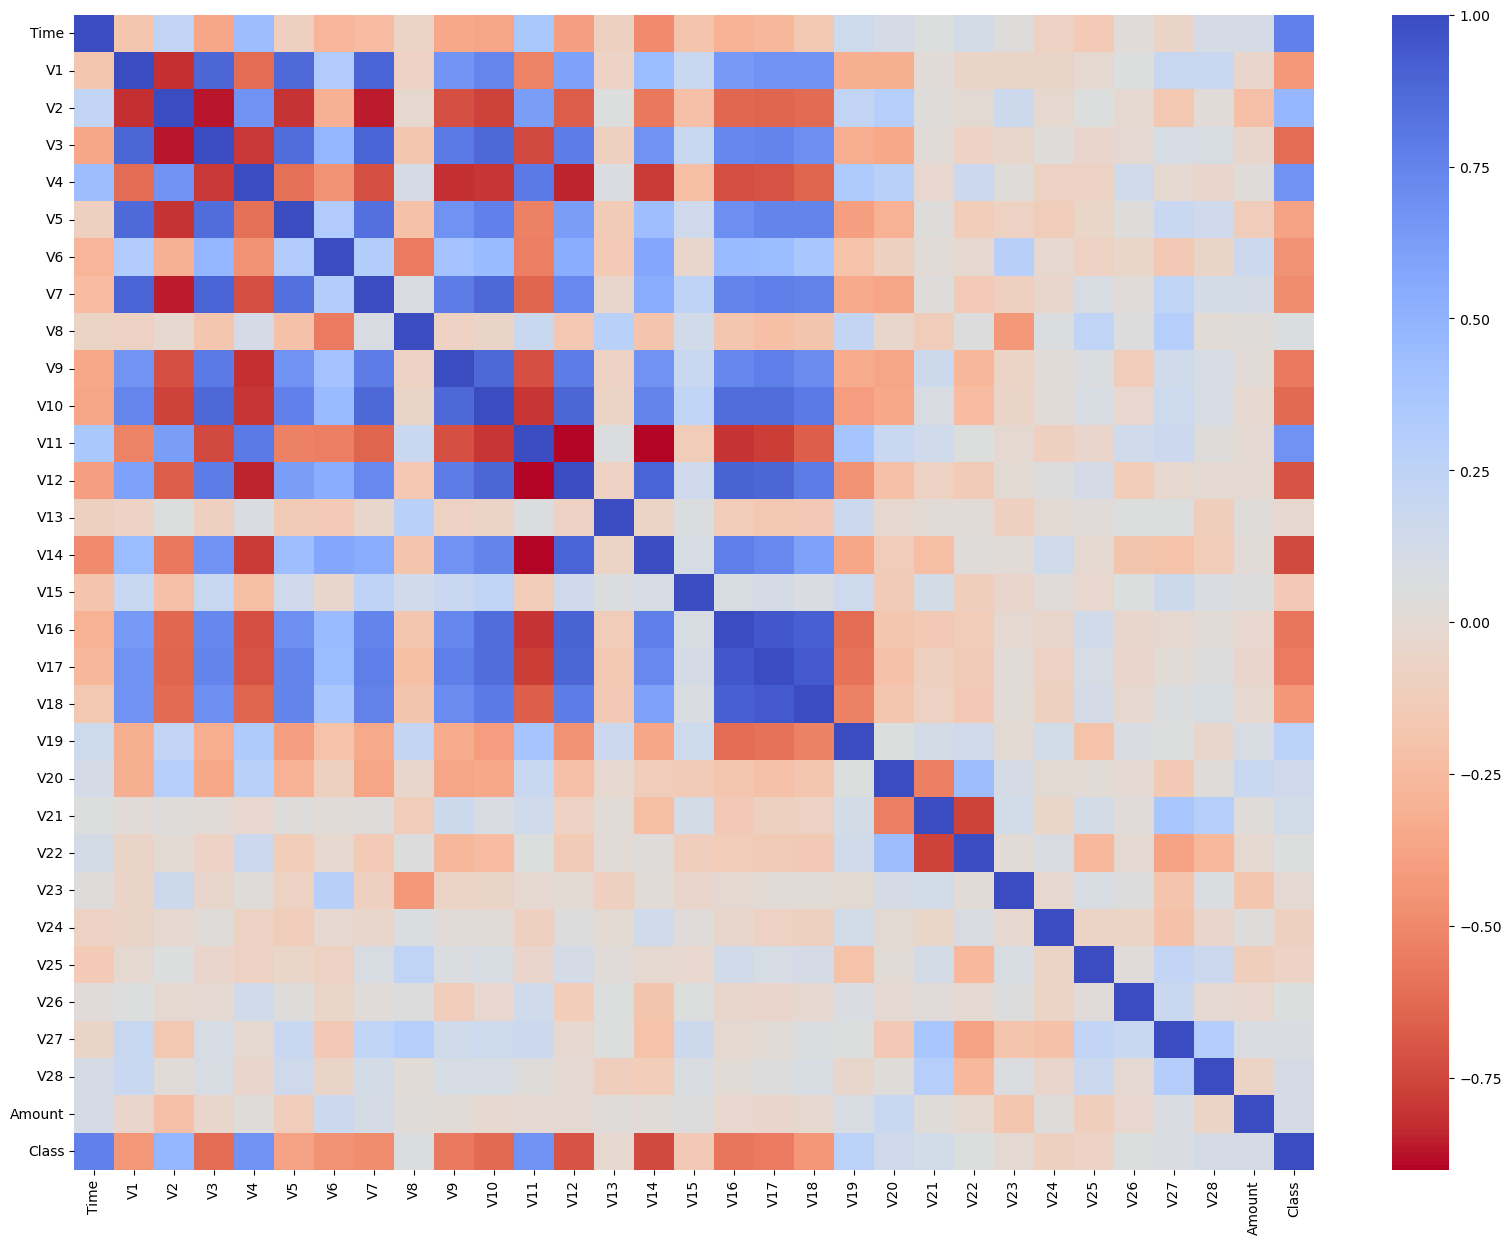

In [15]:
# Correlations and box plot distributions
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
corr = undersample_df.corr()
sns.heatmap(corr, cmap="coolwarm_r", ax=ax)
plt.savefig('./images/correlations.png', dpi=300)

In [16]:
undersample_df[undersample_df["Class"] == 1]["V14"].mean() # Example of negatively being associated with response variable (1)

-6.971722894107602

In [17]:
undersample_df[undersample_df["Class"] == 1]["V4"].mean() # Example of positively being associated with response variable (1)

4.542029104423093

In [18]:
# Generalized correlations pairs plot for large extremes of correlation
# Time/Amounts excluded since visualizations provide little value of interest compared to other PCA features
# Time/Amounts to be visualized with other distributions plots
excludes = ["Time", "Class"]
neg_corrs = [item for item in list(corr.loc[corr["Class"] <= -0.6].index) if item not in excludes]
pos_corrs = [item for item in list(corr.loc[corr["Class"] >= 0.6].index) if item not in excludes]

In [19]:
undersample_df["Class"].unique()

array([0, 1], dtype=int64)

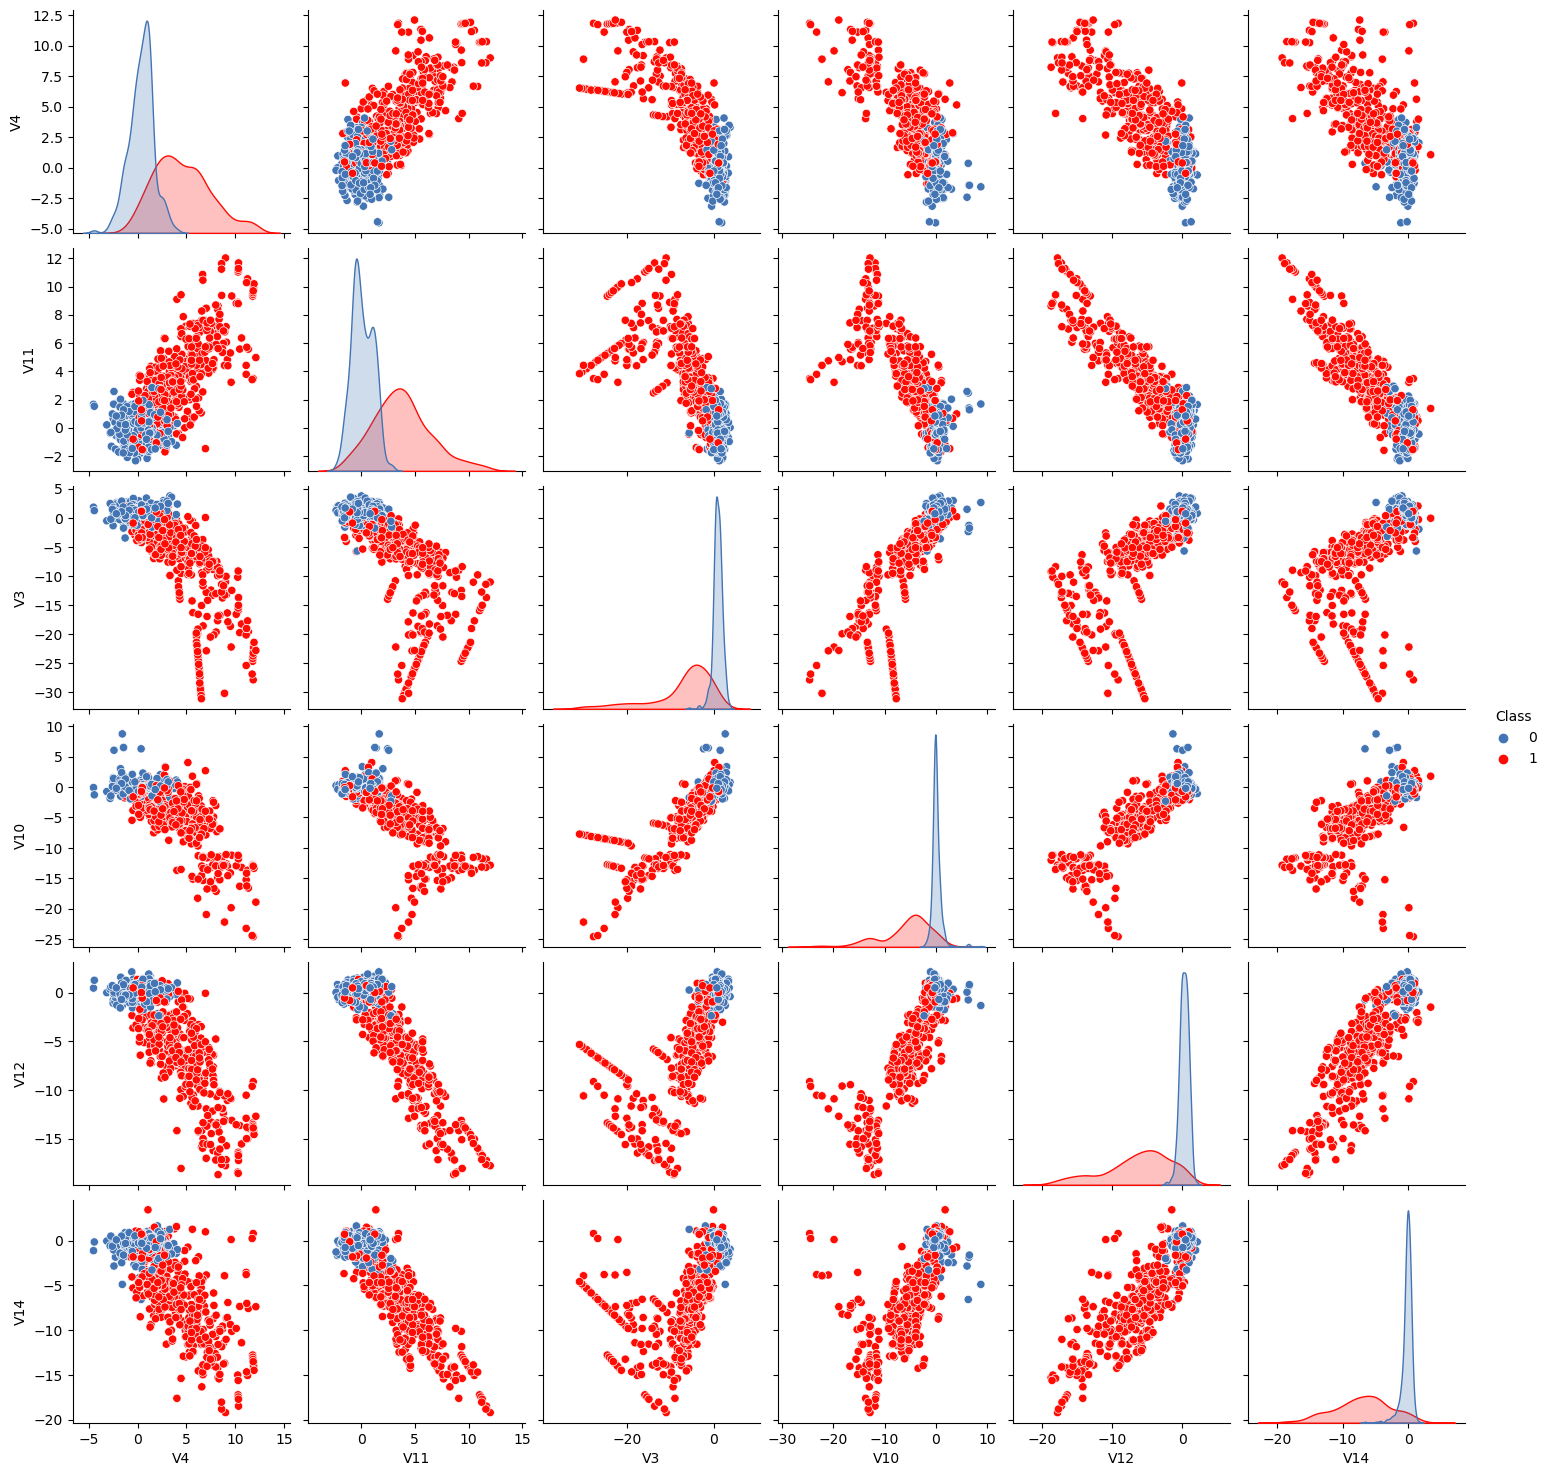

In [20]:
# Pairs plot of undersampled dataframe, scaled features are easy to discern between each other
sns.pairplot(undersample_df, hue="Class", vars=pos_corrs + neg_corrs)
plt.savefig('./images/pairsplot.png', dpi=300)

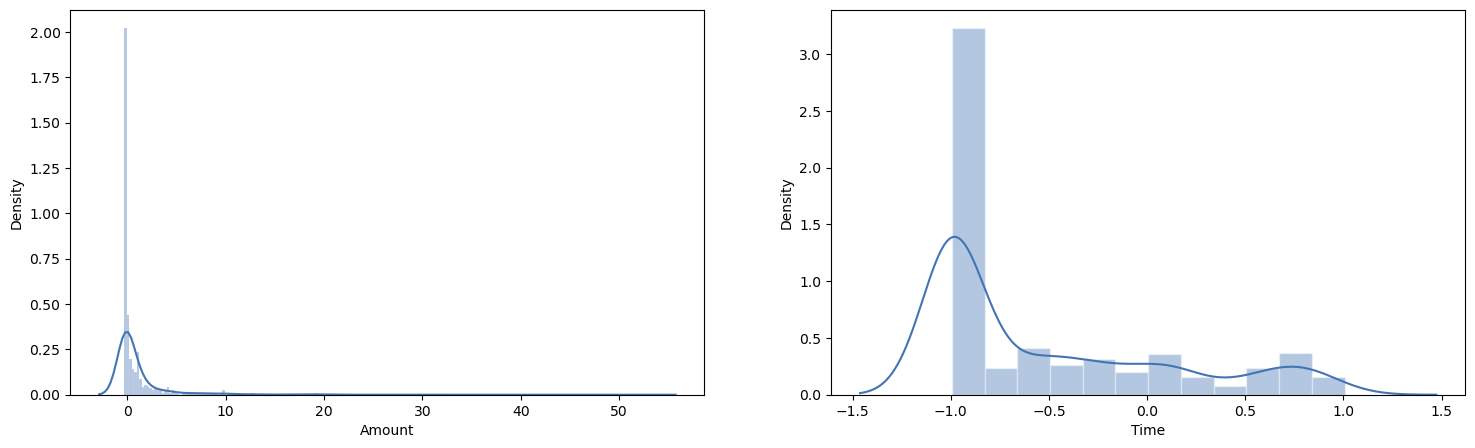

In [21]:
# Example distributions of Amounts and Time between first transaction
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.histplot(
    undersample_df["Amount"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    ax=ax[0]
)

sns.histplot(
    undersample_df["Time"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
    ax=ax[1]
)
plt.savefig('./images/histplots.png', dpi=300)

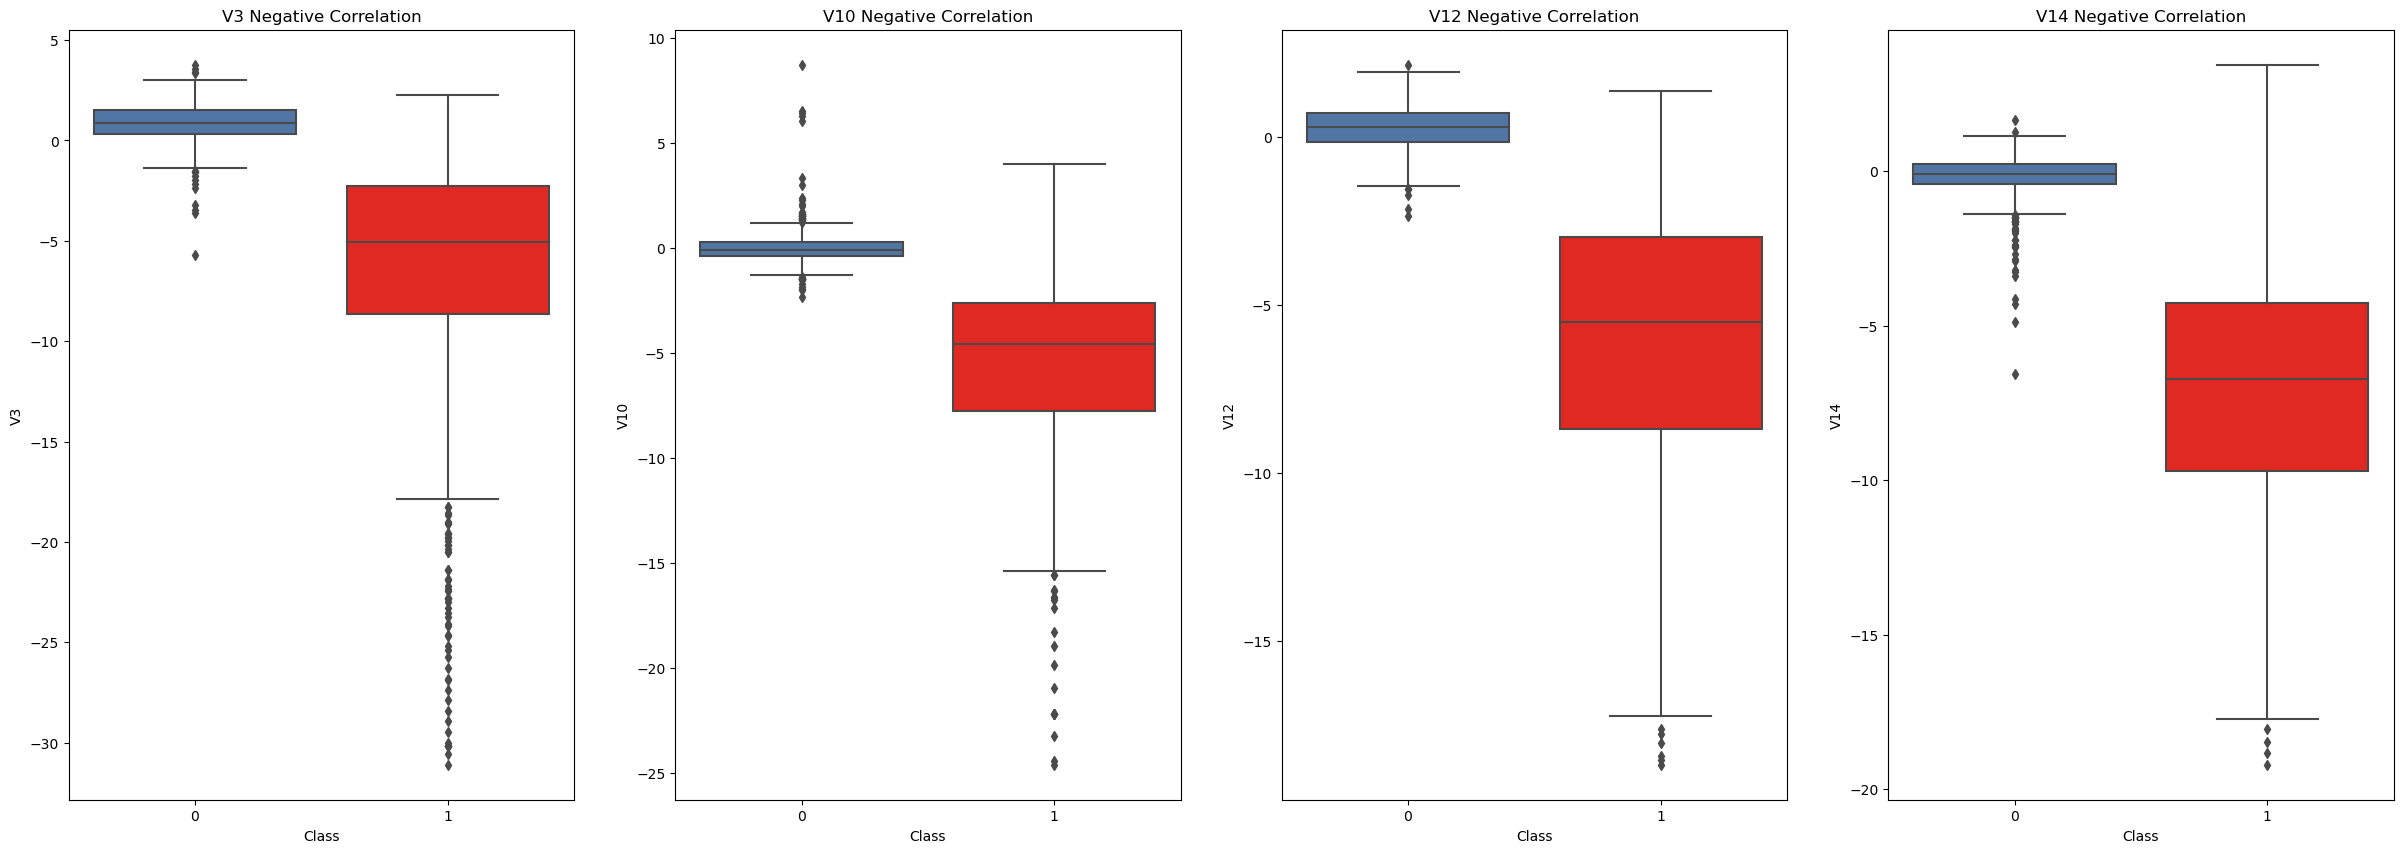

In [22]:
# Box plots of highly correlated features with Class
f, axes = plt.subplots(ncols=len(neg_corrs), figsize=(30, 10))

for idx, neg_corr in enumerate(neg_corrs):
    sns.boxplot(data=undersample_df, x="Class", y=neg_corr, ax=axes[idx])
    axes[idx].set_title("{0} Negative Correlation".format(neg_corr))
    
plt.savefig('./images/negcorrelations.png', dpi=300)

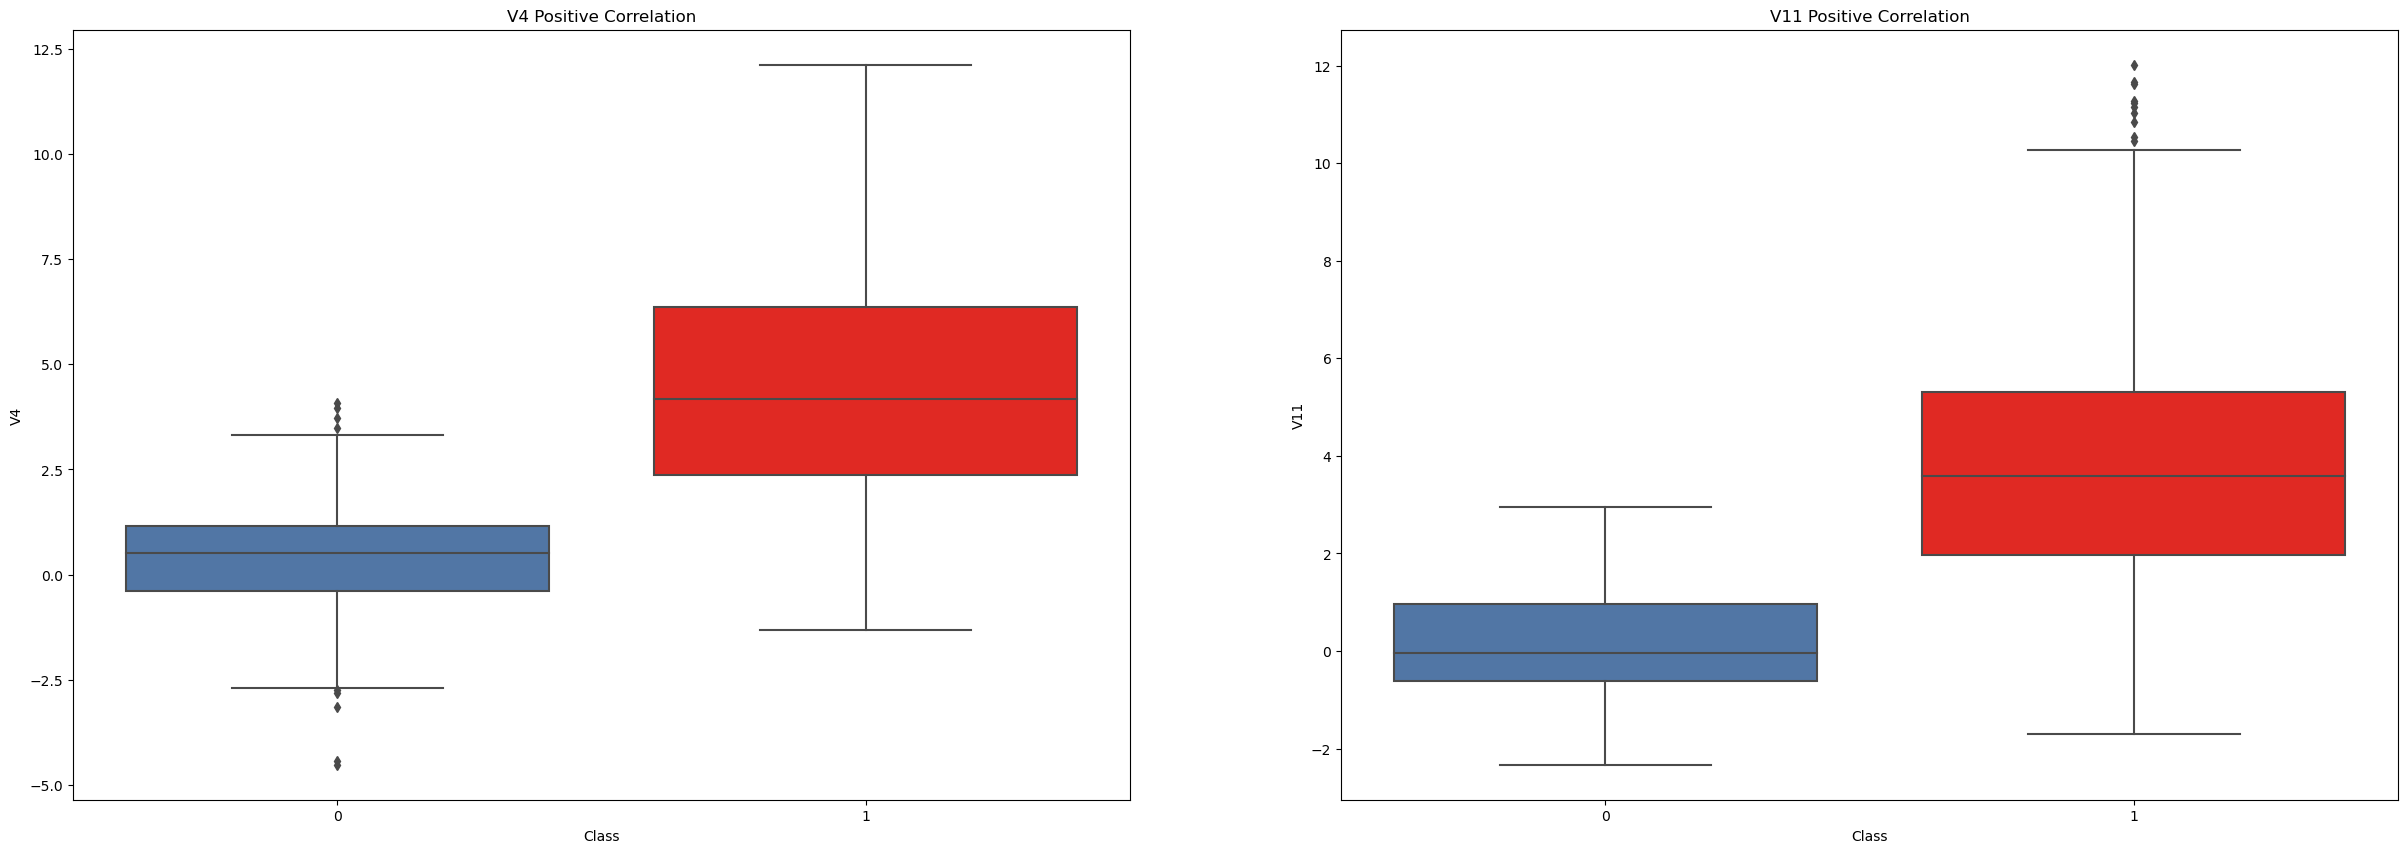

In [23]:
f, axes = plt.subplots(ncols=len(pos_corrs), figsize=(30, 10))

for idx, pos_corr in enumerate(pos_corrs):
    sns.boxplot(data=undersample_df, x="Class", y=pos_corr, ax=axes[idx])
    axes[idx].set_title("{0} Positive Correlation".format(pos_corr))
    
plt.savefig('./images/poscorrelations.png', dpi=300)

In [24]:
# Removing outliers associated with extreme cases of fraud
# Better fit for our model as to not overfit as well as baseline model for LogisticRegression would improve

# Interquartile Range outlier removal
# Remove outliers (For highly correlated features)
undersample_clean = undersample_df.copy()
for feature in pos_corrs + neg_corrs:
    fraud_vals = undersample_df[feature].loc[undersample_df['Class'] == 1].values
    q25, q75 = np.percentile(fraud_vals, 25), np.percentile(fraud_vals, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feature_iq = q75 - q25
    print('iqr: {}'.format(feature_iq))

    feature_cutoff = feature_iq * 1.5
    feature_lower, feature_upper = q25 - feature_cutoff, q75 + feature_cutoff
    print('Cut Off: {}'.format(feature_cutoff))
    print('{0} Lower: {1}'.format(feature, feature_lower))
    print('{0} Upper: {1}'.format(feature, feature_upper))

    outliers = [x for x in fraud_vals if x < feature_lower or x > feature_upper]
    print('Feature {0} Outliers for Fraud Cases: {1}'.format(feature, len(outliers)))
    print('{0} outliers: {1}'.format(feature, outliers))

    undersample_clean = undersample_clean.drop(undersample_clean[(undersample_clean[feature] > feature_upper) | (undersample_clean[feature] < feature_lower)].index)
    print("-----------------------------------------------------------------")

Quartile 25: 2.373049531845565 | Quartile 75: 6.3487294567140955
iqr: 3.9756799248685306
Cut Off: 5.963519887302796
V4 Lower: -3.5904703554572315
V4 Upper: 12.312249344016891
Feature V4 Outliers for Fraud Cases: 0
V4 outliers: []
-----------------------------------------------------------------
Quartile 25: 1.973396660607005 | Quartile 75: 5.307077600096335
iqr: 3.33368093948933
Cut Off: 5.000521409233995
V11 Lower: -3.0271247486269903
V11 Upper: 10.30759900933033
Feature V11 Outliers for Fraud Cases: 10
V11 outliers: [11.6692047358121, 12.0189131816199, 11.6197234753825, 11.0270590938161, 10.5452629545898, 11.1524905985837, 11.2779207278067, 11.228470279576, 10.8530116481991, 10.446846814514]
-----------------------------------------------------------------
Quartile 25: -8.643489255766207 | Quartile 75: -2.27618472719291
iqr: 6.367304528573297
Cut Off: 9.550956792859946
V3 Lower: -18.194446048626155
V3 Upper: 7.274772065667036
Feature V3 Outliers for Fraud Cases: 53
V3 outliers: [-24.

<AxesSubplot: xlabel='Class', ylabel='V3'>

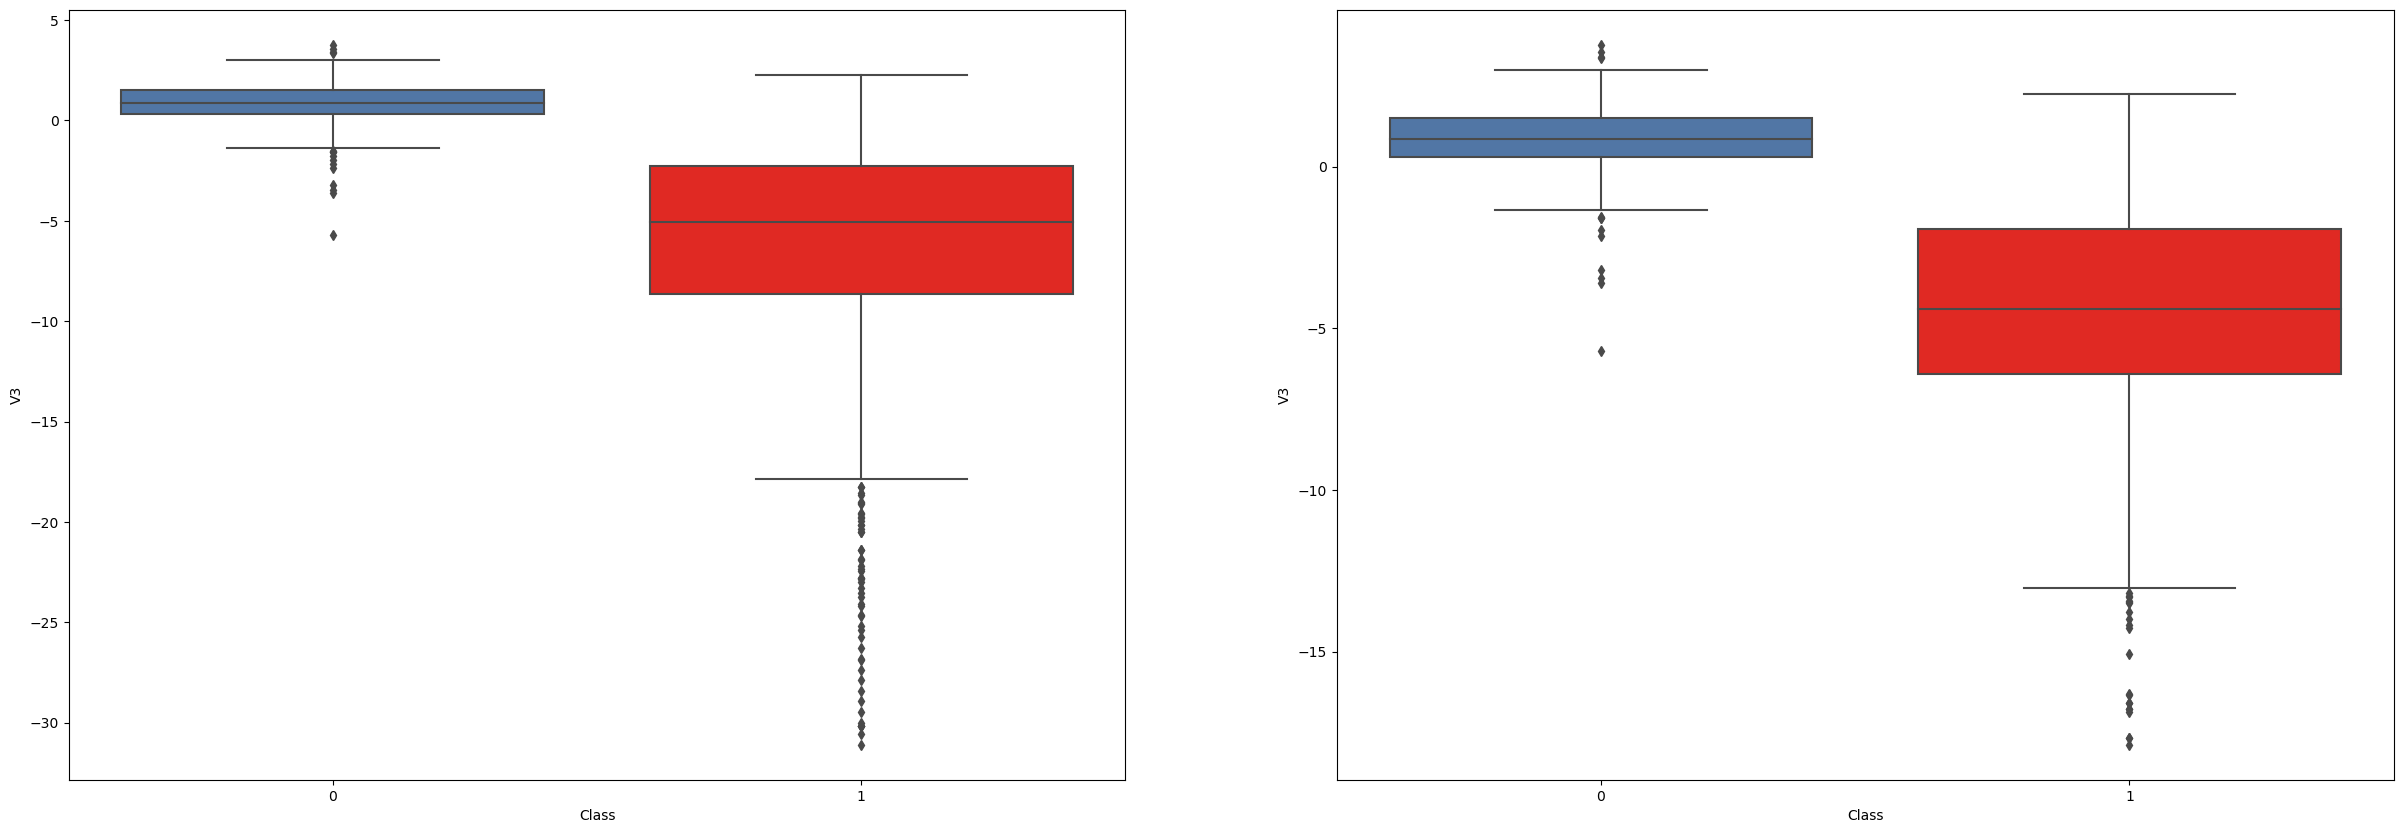

In [25]:
# New undersample with outliers removed, less outliers in specific pos/neg corr features
f, axes = plt.subplots(ncols=2, figsize=(30, 10))

sns.boxplot(data=undersample_df, x="Class", y="V3", ax=axes[0])
sns.boxplot(data=undersample_clean, x="Class", y="V3", ax=axes[1])

### Classifiers with Undersampling

In this case we will use a baseline model of LogisticRegression since it is a generalized supervised classification model, we will compare with Boosting/Bagging approach to determine if there is any performance differences as well as prediction performance. Also determine if we can improve this prediction performance since fraud models must have low SLA times.

Selection of models are based on commonly use algorithms in the financial world (nonlinear based models) especially boosting/bagging models to reduce variance for less chance of overfitting the data. A baseline linear model of LogisticRegression will also be used for comparison.

- LogisticRegression (simple linear classifier for baseline)
- RandomForest is based on concept of bagging
- XGBoost is the latest algorithm used for boosting (see bagging vs. boosting)
- CatBoost is an alternative to XGBoost with performance increases and can also adapt to non numerical features (not useful in this case), however this was added just to have another comparison for performance considerations (see benchmarks for which is best for overall production readiness)

In [26]:
# We need to keep a holdout/test dataset that has no bias introduced from training the models
# Use Stratified sampling to maintain a separate original test dataset from this set
X = df.drop('Class', axis=1)
y = df['Class']

strat_sampling = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in strat_sampling.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    X_train_original, X_test_original = X.iloc[train_index], X.iloc[test_index]
    y_train_original, y_test_original = y.iloc[train_index], y.iloc[test_index]

Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [27]:
# Class distributions of labels
train_unique_label, train_counts_label = np.unique(y_train_original.values, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_test_original.values, return_counts=True)

print('Class Distributions: \n')
print(train_counts_label/ len(y_train_original.values))
print(test_counts_label/ len(y_test_original.values))

Class Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [28]:
# Set train/test split for undersampling
X_undersample = undersample_clean.drop("Class", axis=1)
y_undersample = undersample_clean["Class"]
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_undersample, y_undersample, 
                                                                            test_size=0.2, random_state=42)

In [29]:
models = {
    "LogisticRegression": {
        # Max iters warning with grid search fit
        "classifier": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        }
    },
    "RandomForest": {
        "classifier": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 250, 500], 
            "max_features": ["sqrt", "log2"], 
            "max_depth": [4, 5, 6], 
            "criterion": ["gini", "entropy"]
        }
    },
    "XGBoost": {
        "classifier": xgb.XGBClassifier(random_state=42),
        "params": {
            'objective':['binary:logistic'],
            'learning_rate': [0.05],
            'max_depth': [4, 5, 6],
            'min_child_weight': [11],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [100, 250, 500]
        }
    },
    "CatBoost": {
        "classifier": CatBoostClassifier(random_state=42, verbose=False),
        "params": {
            'iterations': [100, 250, 500],
            'depth': [4, 5, 6],
            'loss_function': ['Logloss', 'CrossEntropy'],
            'l2_leaf_reg': np.logspace(-20, -19, 3),
            'leaf_estimation_iterations': [10]
         }
    }
}

In [30]:
# Training set with default params
for key, model in models.items():
    model["classifier"].fit(X_train_under, y_train_under)
    training_score = cross_val_score(model["classifier"], X_train_under, y_train_under, cv=10, n_jobs=-1)
    print("Classifiers: ", model["classifier"].__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 98.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 100.0 % accuracy score
Classifiers:  XGBClassifier Has a training score of 100.0 % accuracy score


iteritems is deprecated and will be removed in a future version. Use .items instead.


Classifiers:  CatBoostClassifier Has a training score of 100.0 % accuracy score


In [31]:
# GridSearchCV Cross Validation hyperparameters
undersample_models = {}
for key, model in models.items():
    print("-----------------------------------------------------")
    print("Running GridSearchCV for {0} with params {1}".format(key, model["params"]))
    grid = GridSearchCV(model["classifier"], model["params"], n_jobs=-1)
    print("Training fit....")
    grid.fit(X_train_under, y_train_under)
    print("CV done")
    undersample_models[key] = grid.best_estimator_
    cv_score = cross_val_score(grid.best_estimator_, X_train_under, y_train_under, cv=10, n_jobs=-1)
    print('{} Cross Validation Score: '.format(key), round(cv_score.mean() * 100, 2).astype(str) + '%')

-----------------------------------------------------
Running GridSearchCV for LogisticRegression with params {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Training fit....
CV done
LogisticRegression Cross Validation Score:  98.49%
-----------------------------------------------------
Running GridSearchCV for RandomForest with params {'n_estimators': [100, 250, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [4, 5, 6], 'criterion': ['gini', 'entropy']}
Training fit....
CV done
RandomForest Cross Validation Score:  99.59%
-----------------------------------------------------
Running GridSearchCV for XGBoost with params {'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [4, 5, 6], 'min_child_weight': [11], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [100, 250, 500]}
Training fit....
CV done
XGBoost Cross Validation Score:  99.86%
-----------------------------------------------------
Running GridSearchCV for CatBoost with params {'iterations': [

iteritems is deprecated and will be removed in a future version. Use .items instead.


CV done
CatBoost Cross Validation Score:  99.73%


In [32]:
for key, model in undersample_models.items():
    print("-------------------------------------")
    print("{0} Model params: {1}".format(key, model.get_params()))

-------------------------------------
LogisticRegression Model params: {'C': 1000, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
-------------------------------------
RandomForest Model params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
-------------------------------------
XGBoost Model params: {'objective': 'binary:logistic', 'use_label_encoder': False, 'base_score': 0.5, 'booster': 'gbtree', 'callbacks': None, 'colsample_bylevel'

In [33]:
def plot_learning_curve(estimator, ax, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    if ylim is not None:
        plt.ylim(*ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Training size')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")

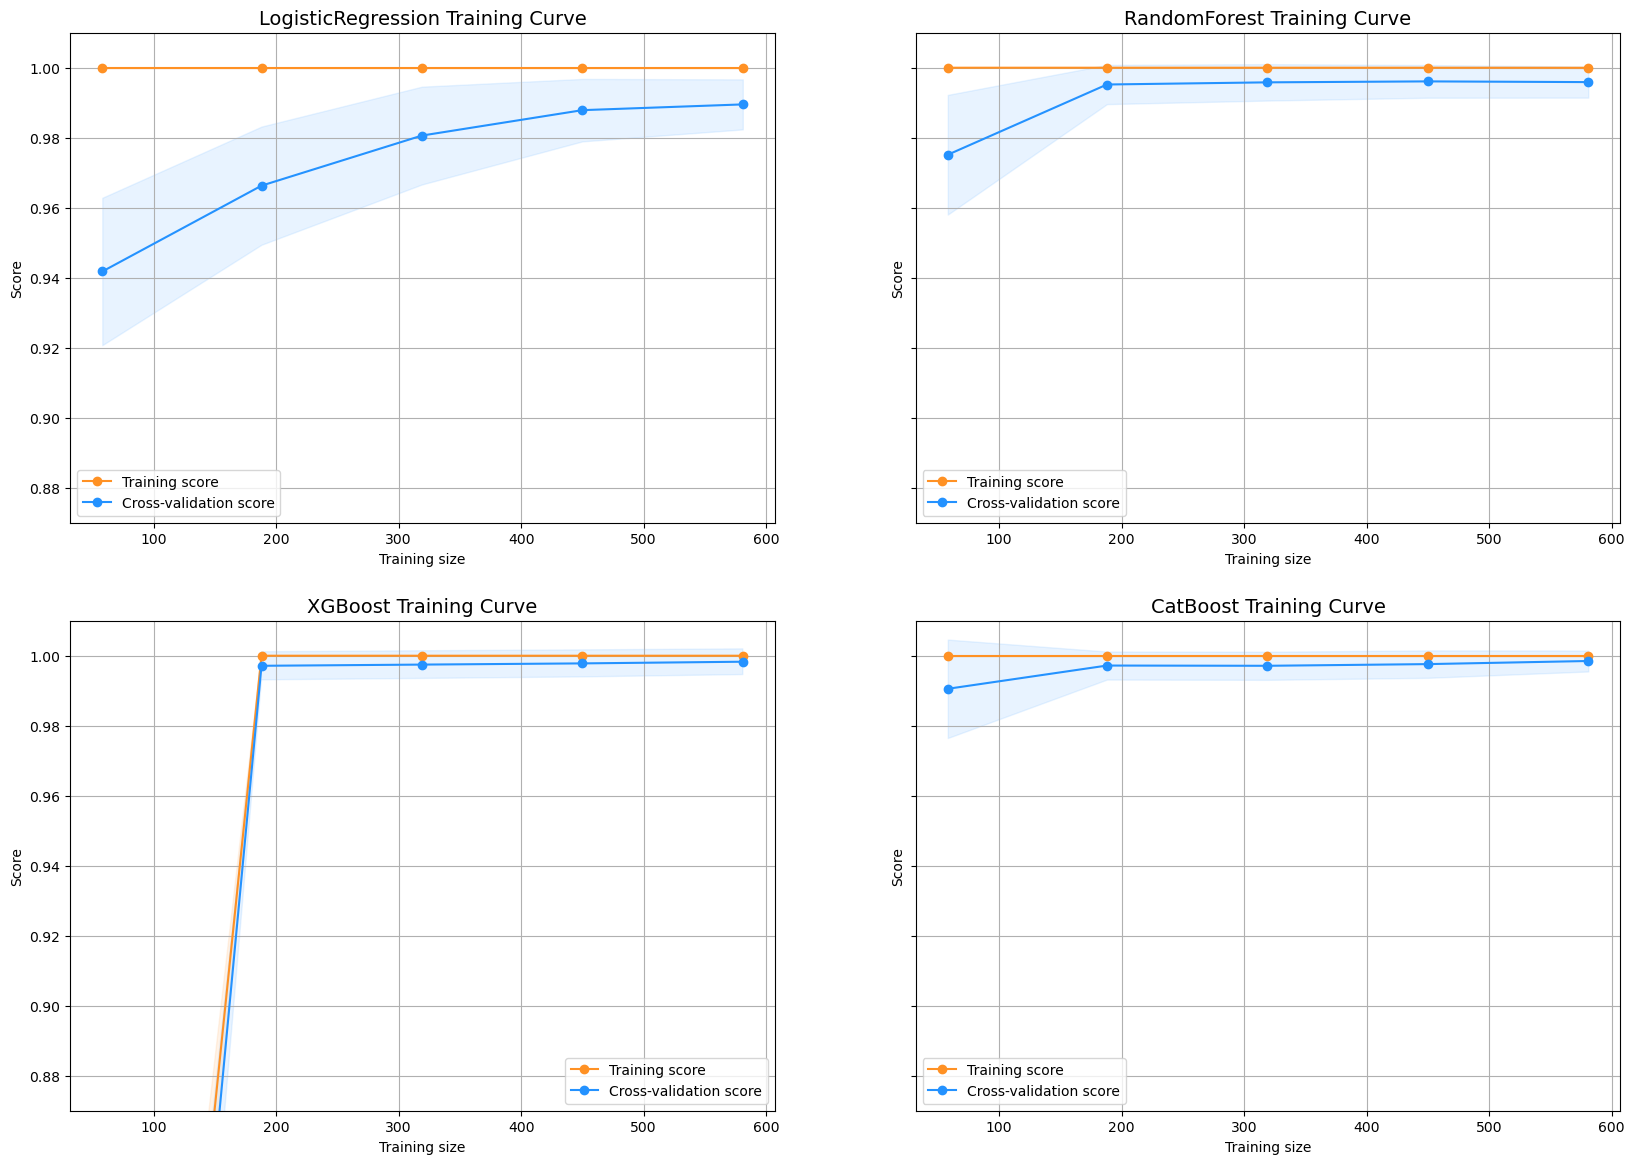

In [34]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(undersample_models['LogisticRegression'], 
                    ax1, 
                    "LogisticRegression Training Curve", 
                    X_train_under, y_train_under, (0.87, 1.01), cv=cv, n_jobs=-1)
plot_learning_curve(undersample_models['RandomForest'], 
                    ax2, 
                    "RandomForest Training Curve", 
                    X_train_under, y_train_under, (0.87, 1.01), cv=cv, n_jobs=-1)
plot_learning_curve(undersample_models['XGBoost'], 
                    ax3, 
                    "XGBoost Training Curve", 
                    X_train_under, y_train_under, (0.87, 1.01), cv=cv, n_jobs=-1)
plot_learning_curve(undersample_models['CatBoost'], 
                    ax4, 
                    "CatBoost Training Curve", 
                    X_train_under, y_train_under, (0.87, 1.01), cv=cv, n_jobs=-1)
plt.savefig('./images/learningcurves.png', dpi=300)

In [35]:
def plot_confusion_matrix(model, ax, title, X_test, y_test, cv=10):
    cm = confusion_matrix(y_test, model.predict(X_test))
    sns.heatmap(cm, annot=True, cmap="rocket_r", ax=ax, fmt='d')
    ax.set_title(title)

iteritems is deprecated and will be removed in a future version. Use .items instead.


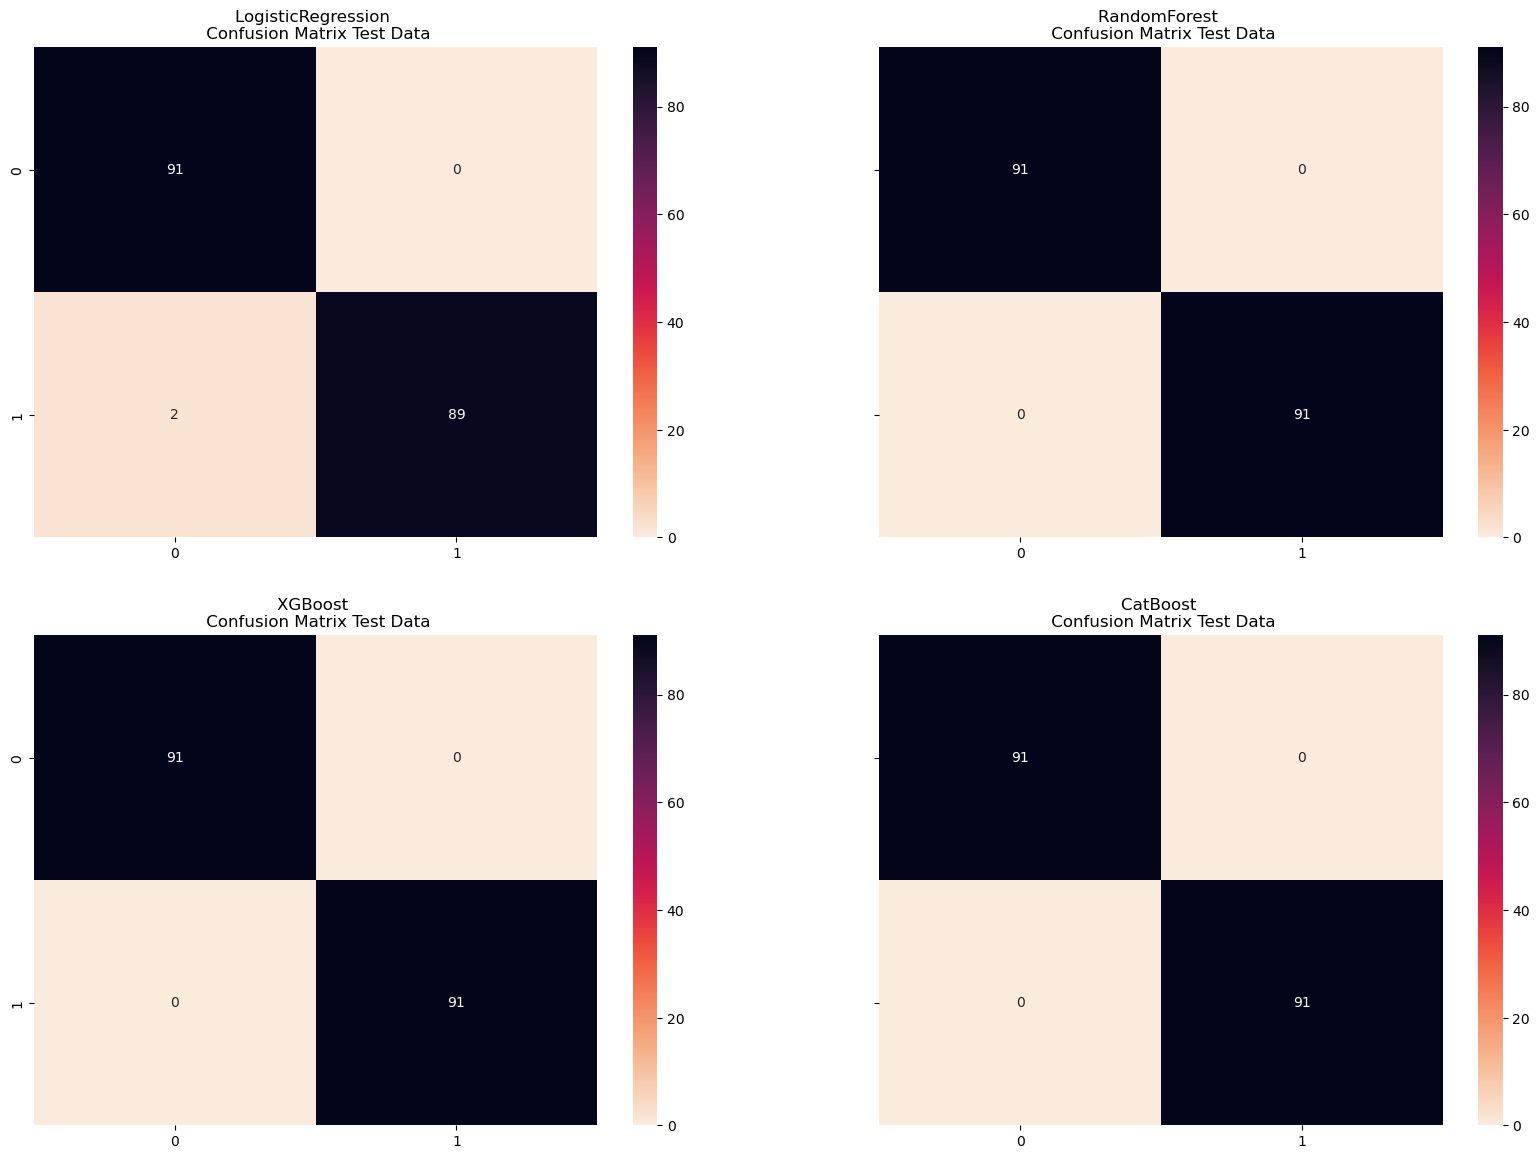

In [36]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
plot_confusion_matrix(undersample_models['LogisticRegression'],
                    ax1, 
                    "LogisticRegression \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(undersample_models['RandomForest'], 
                    ax2, 
                    "RandomForest \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(undersample_models['XGBoost'], 
                    ax3, 
                    "XGBoost \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(undersample_models['CatBoost'], 
                    ax4, 
                    "CatBoost \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)

### Model Latency Performance

Check notebook for `Benchmarks` for model latency comparisons

### Oversampling Approach SMOTE (Synthetic Minority Oversampling)

SMOTE is a synthetic oversampling algorithm which generates new data based on similar features (distance space/math). Read more via official documentation, Scikit-Learn has a SMOTE sampling strategy available.

In [37]:
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Compare SMOTE Technique with undersampling models (X_test, y_test), (X, y)
smote = SMOTE(sampling_strategy="minority", random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [39]:
X_train_sm.shape

(454902, 30)

In [40]:
print('0 (Non-Fraud)', (y_train_sm.value_counts()[0] / y_train_sm.shape[0] * 100), '%')
print('1 (Fraud)', (y_train_sm.value_counts()[1] / y_train_sm.shape[0] * 100), '%')

0 (Non-Fraud) 50.0 %
1 (Fraud) 50.0 %


In [41]:
# Test parameters based on original training GridSearchCV, not a best practice, however
# due to data size of the actual SMOTE balanced dataset >400k transactions
# We will employ set parameters for creating the models to compare
# In a production scenario we would train and run a GridSearchCV for more hyperparameters
# and select the best model
test_models = {
    "LogisticRegression": {
        # Max iters warning with grid search fit
        "classifier": LogisticRegression(random_state=42, max_iter=1000),
        "params": {
            'C': [1000]
        }
    },
    "RandomForest": {
        "classifier": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100], 
            "max_features": ["sqrt"], 
            "max_depth": [4], 
            "criterion": ["gini"]
        }
    },
    "XGBoost": {
        "classifier": xgb.XGBClassifier(random_state=42),
        "params": {
            'objective':['binary:logistic'],
            'learning_rate': [0.05],
            'max_depth': [4],
            'min_child_weight': [11],
            'subsample': [0.8],
            'colsample_bytree': [0.7],
            'n_estimators': [100]
        }
    },
    "CatBoost": {
        "classifier": CatBoostClassifier(random_state=42, verbose=False),
        "params": {
            'iterations': [100],
            'depth': [4],
            'loss_function': ['Logloss'],
            'l2_leaf_reg': [1e-20],
            'leaf_estimation_iterations': [10]
         }
    }
}

In [42]:
# GridSearchCV Cross Validation hyperparameters
smote_models = {}
for key, model in test_models.items():
    print("-----------------------------------------------------")
    print("Running GridSearchCV for {0} with params {1}".format(key, model["params"]))
    grid = GridSearchCV(model["classifier"], model["params"], n_jobs=-1)
    print("Training fit....")
    grid.fit(X_train_sm, y_train_sm)
    print("CV done")
    smote_models[key] = grid.best_estimator_
    cv_score = cross_val_score(grid.best_estimator_, X_train_sm, y_train_sm, cv=10, n_jobs=-1)
    print('{} Cross Validation Score: '.format(key), round(cv_score.mean() * 100, 2).astype(str) + '%')

-----------------------------------------------------
Running GridSearchCV for LogisticRegression with params {'C': [1000]}
Training fit....
CV done
LogisticRegression Cross Validation Score:  94.94%
-----------------------------------------------------
Running GridSearchCV for RandomForest with params {'n_estimators': [100], 'max_features': ['sqrt'], 'max_depth': [4], 'criterion': ['gini']}
Training fit....
CV done
RandomForest Cross Validation Score:  93.65%
-----------------------------------------------------
Running GridSearchCV for XGBoost with params {'objective': ['binary:logistic'], 'learning_rate': [0.05], 'max_depth': [4], 'min_child_weight': [11], 'subsample': [0.8], 'colsample_bytree': [0.7], 'n_estimators': [100]}
Training fit....
CV done
XGBoost Cross Validation Score:  97.64%
-----------------------------------------------------
Running GridSearchCV for CatBoost with params {'iterations': [100], 'depth': [4], 'loss_function': ['Logloss'], 'l2_leaf_reg': [1e-20], 'leaf_e

iteritems is deprecated and will be removed in a future version. Use .items instead.


CV done
CatBoost Cross Validation Score:  96.26%


iteritems is deprecated and will be removed in a future version. Use .items instead.


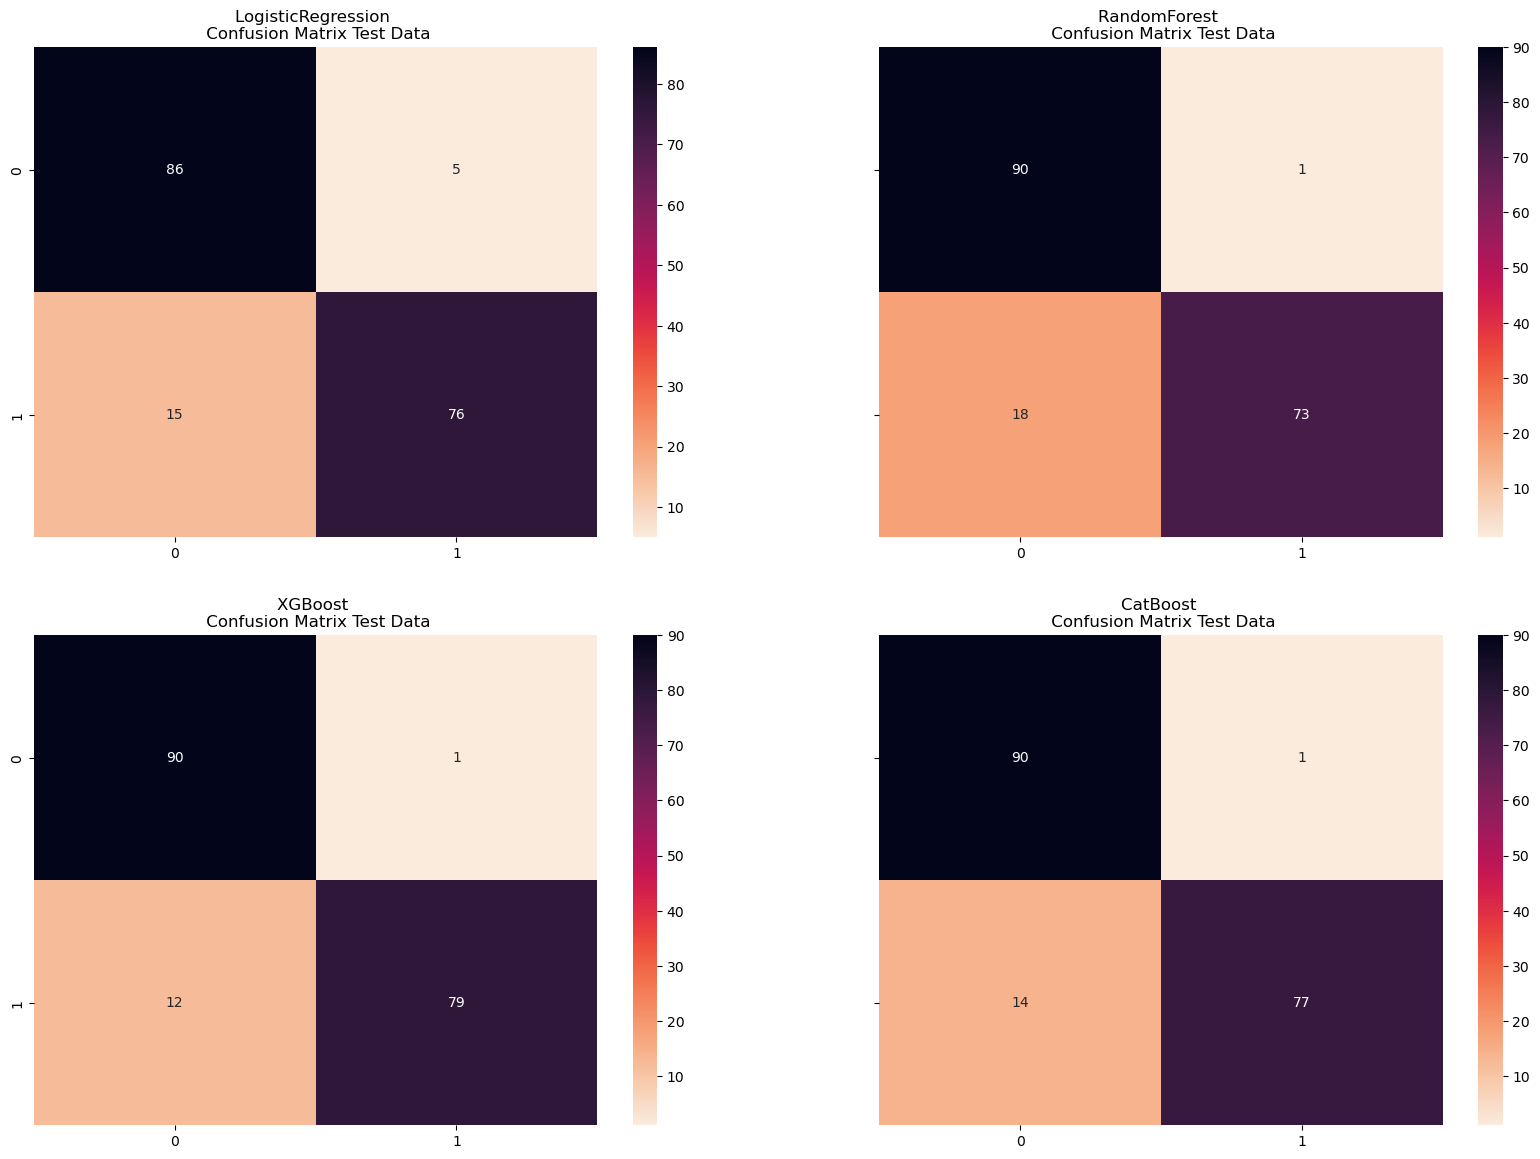

In [43]:
# Plot SMOTE trained models against undersampled test dataset for an apples to apples comparison
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
plot_confusion_matrix(smote_models['LogisticRegression'],
                    ax1, 
                    "LogisticRegression \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(smote_models['RandomForest'], 
                    ax2, 
                    "RandomForest \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(smote_models['XGBoost'], 
                    ax3, 
                    "XGBoost \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(smote_models['CatBoost'], 
                    ax4, 
                    "CatBoost \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)

plt.savefig('./images/confusionmatrix.png', dpi=300)

In [44]:
# Compare original undersampled LogisticRegression baseline with SMOTE for their respective holdout datasets
y_pred = undersample_models["LogisticRegression"].predict(X_test_under)
undersample_accuracy = accuracy_score(y_test_under, y_pred)

y_pred_sm = smote_models["LogisticRegression"].predict(X_test)
oversample_accuracy = accuracy_score(y_test, y_pred_sm)

In [45]:
# We have slightly less accuracy since we did not remove outliers from the original dataset for the SMOTE training phase
print("Undersample test dataset {}".format(X_test_under.shape))
print("Undersample accuracy LogisticRegression baseline: {}".format(undersample_accuracy))
print("Oversample test dataset {}".format(X_test.shape))
print("Oversample SMOTE accuracy LogisticRegression baseline: {}".format(oversample_accuracy))

Undersample test dataset (182, 30)
Undersample accuracy LogisticRegression baseline: 0.989010989010989
Oversample test dataset (56962, 30)
Oversample SMOTE accuracy LogisticRegression baseline: 0.9752115445384643


In [46]:
# Creating synthetic samples before cross validation can introduce data leakage
# We want to apply SMOTE during the pipeline fitting process so that we are cross validating correctly

accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

random_cv = RandomizedSearchCV(xgb.XGBClassifier(random_state=42), test_models["XGBoost"]["params"], n_iter=1, n_jobs=-1)

original_Xtrain = X_train_original.values
original_Xtest = X_test_original.values
original_ytrain = y_train_original.values
original_ytest = y_test_original.values

# SMOTE via pipeline during, not before, cross validation sampling
for train, test in strat_sampling.split(original_Xtrain, original_ytrain):
    # Build the pipeline, add SMOTE
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), random_cv) # SMOTE happens during Cross Validation not before..
    # Fit data
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    # Predict
    preds = random_cv.best_estimator_.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], preds))
    recall_lst.append(recall_score(original_ytrain[test], preds))
    f1_lst.append(f1_score(original_ytrain[test], preds))
    auc_lst.append(roc_auc_score(original_ytrain[test], preds))
    
del original_Xtrain
del original_Xtest
del original_ytrain
del original_ytest
    
print("Stratified Sampling pipeline stats")
print("-----------------------------------------")
print("Mean Accuracy: {}".format(np.mean(accuracy_lst)))
print("Mean Precision: {}".format(np.mean(precision_lst)))
print("Mean Recall: {}".format(np.mean(recall_lst)))
print("Mean F1: {}".format(np.mean(f1_lst)))

Stratified Sampling pipeline stats
-----------------------------------------
Mean Accuracy: 0.96755705355114
Mean Precision: 0.211185825059291
Mean Recall: 0.903667640376501
Mean F1: 0.2407226710982222


In [47]:
# Save models
smote_models["XGBoost"].save_model('./models/model_large.json')
joblib.dump(smote_models["XGBoost"], "./models/model_large.bin")
undersample_models["XGBoost"].save_model('./models/model_small.json')
joblib.dump(undersample_models["XGBoost"], "./models/model_small.bin")

['model_small.bin']

### Feature Explainability and Contributions

SHAP values are commonly use for tree based algorithms as well as other algorithms not just nonlinear for explainability of feature contributions to model outputs. Good documentation here: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [48]:
# Load small model (Undersampled approach for computational purposes)
model = joblib.load("./models/model_small.bin")

In [49]:
# Feature importance
explainer = shap.Explainer(model, X_undersample)
shap_values = explainer(X_undersample)

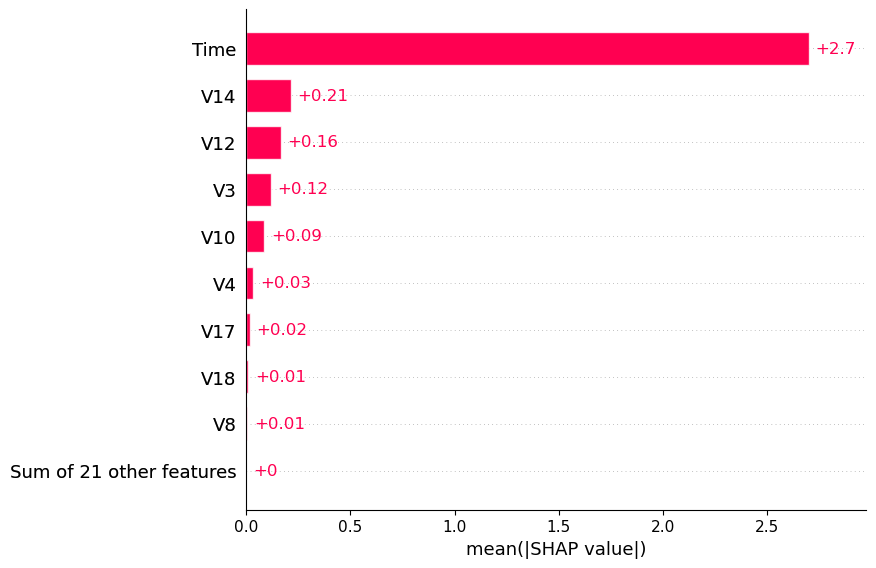

In [50]:
# Overall feature impacts by Mean Absolute Average
shap.plots.bar(shap_values, show=False)
plt.savefig("shapvalues.png", dpi=300)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


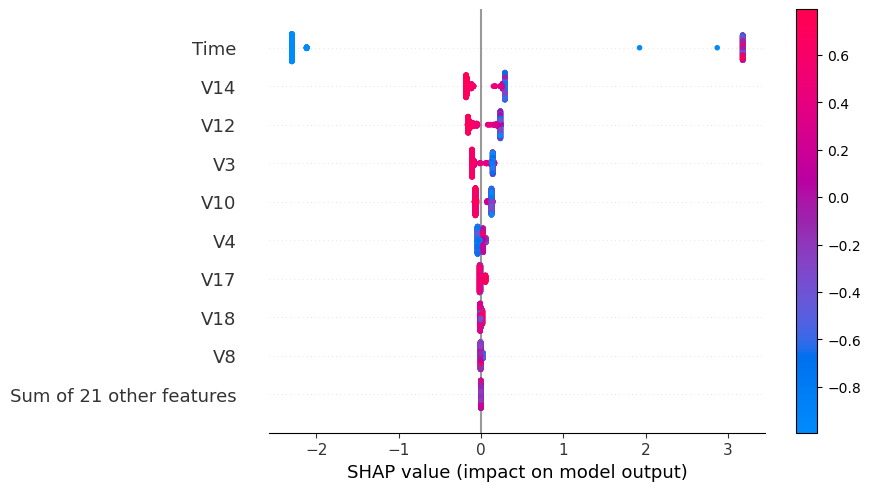

In [51]:
# More detailed individual contributions
shap.plots.beeswarm(shap_values, show=False, color_bar=False)
plt.colorbar()
plt.savefig("shapbeeswarm.png", dpi=300)
plt.show()

In [52]:
tree_explainer = shap.TreeExplainer(model)
shap_values_tree = tree_explainer.shap_values(X_undersample)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [53]:
# Example of a single data point on how features push to one direction (1, Red) or another (0, Blue)
# On average baseline 0.001278 we have core features V14, etc.
# For example V14 decreases fraud baseline contribution for this sample by being 0.4821
shap.force_plot(tree_explainer.expected_value, shap_values_tree[0,:], X_undersample.iloc[0,:])

In [54]:
# In this case the sample is fraud, V14 being a value of -9.861 along with Time for example, pushes this
# sample to be classified as a fraud case
shap.force_plot(tree_explainer.expected_value, shap_values_tree[1,:], X_undersample.iloc[1,:])

### Model Thresholds Probabilities and Precision/Recall Tradeoff

More can be done with the analysis including testing recall/precision rates by alterting the probability threshold depending on what our clients/business wants. In most cases we would probably want to tone down the false positives as much as possible since we do not want our customers complaining if their transactions are constantly being declined. However we also want to not have false negatives because fraud is serious consequence on customers.

Another improvement to this analysis would be to use more modern models such as Tensorflow/Pytorch using a baseline Neural net to test model performance on class imbalance.

Regarding final model on full test dataset we can see a significant decrease in precision performance (true positives that are actually true). We can change our model threshold to have more fraud cases "slip through" our model which would make more sense considering the number of false positives identified by the model would be far too many in production.

A good threshold would be between 0.7 and 0.9 since we are not trading as much in terms of recall with our precision improvements. We also get a slight accuracy improvement increasing our model threshold.

In [55]:
final_model = joblib.load("./models/model_large.bin")

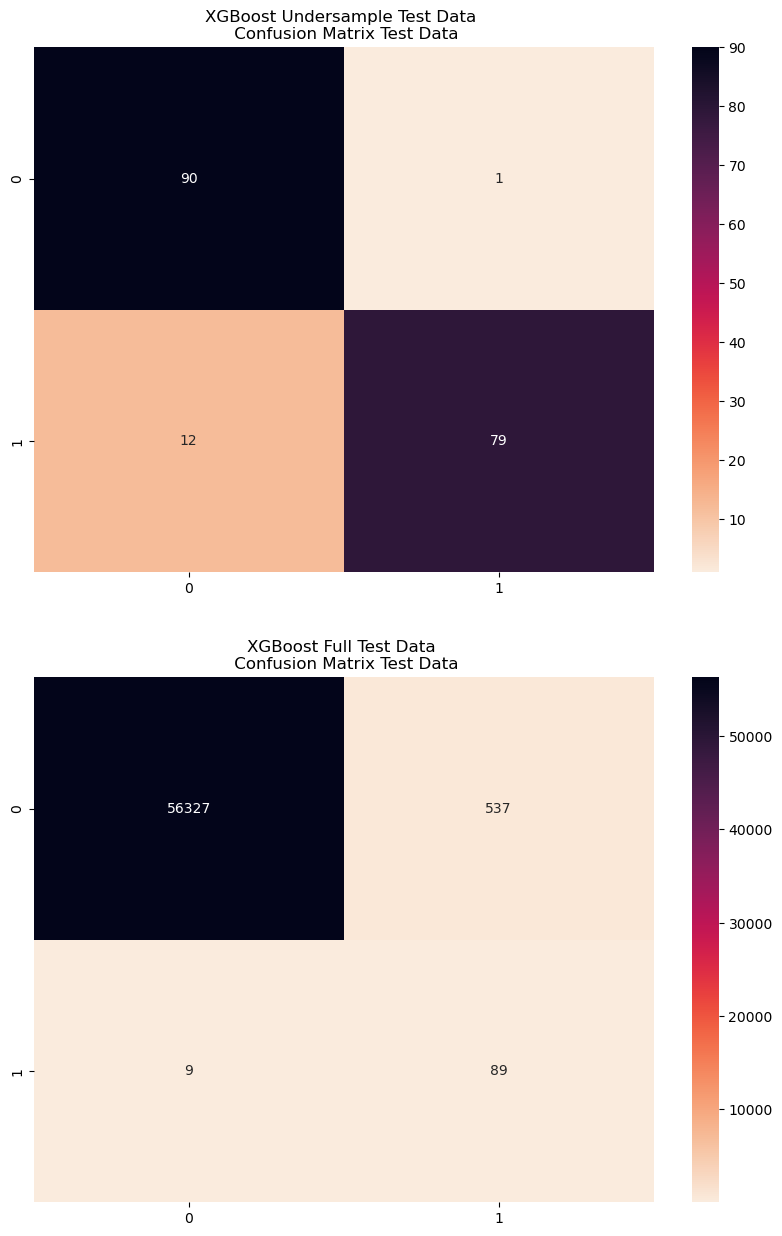

In [56]:
# Plot against original test dataset with full samples
f, (ax1, ax2) = plt.subplots(2,1, figsize=(10,15))
plot_confusion_matrix(final_model,
                    ax1,
                    "XGBoost Undersample Test Data \n Confusion Matrix Test Data", 
                    X_test_under, y_test_under, cv=10)
plot_confusion_matrix(final_model,
                    ax2,
                    "XGBoost Full Test Data \n Confusion Matrix Test Data", 
                    X_test, y_test, cv=10)

In [57]:
print("F1 Score on full test dataset for final model: {}".format(f1_score(y_test, final_model.predict(X_test))))
print("Precision Score on full test dataset for final model: {}".format(precision_score(y_test, final_model.predict(X_test))))

F1 Score on full test dataset for final model: 0.24585635359116018
Precision Score on full test dataset for final model: 0.14217252396166133


In [58]:
# Change threshold for precision/recall tradeoff
cm = confusion_matrix(y_test, final_model.predict(X_test))

------------------------------------------
Threshold: 0.1
Accuracy Score on full test dataset for final model: 0.8611706049647133
Precision Score on full test dataset for final model: 0.011752938234558639
Recall Score on full test dataset for final model: 0.9591836734693877
------------------------------------------
Threshold: 0.2
Accuracy Score on full test dataset for final model: 0.9379410835293704
Precision Score on full test dataset for final model: 0.02540734603700635
Recall Score on full test dataset for final model: 0.9387755102040817
------------------------------------------
Threshold: 0.3
Accuracy Score on full test dataset for final model: 0.9672939854639936
Precision Score on full test dataset for final model: 0.04673857216230098
Recall Score on full test dataset for final model: 0.9285714285714286
------------------------------------------
Threshold: 0.4
Accuracy Score on full test dataset for final model: 0.9836908816403919
Precision Score on full test dataset for final 

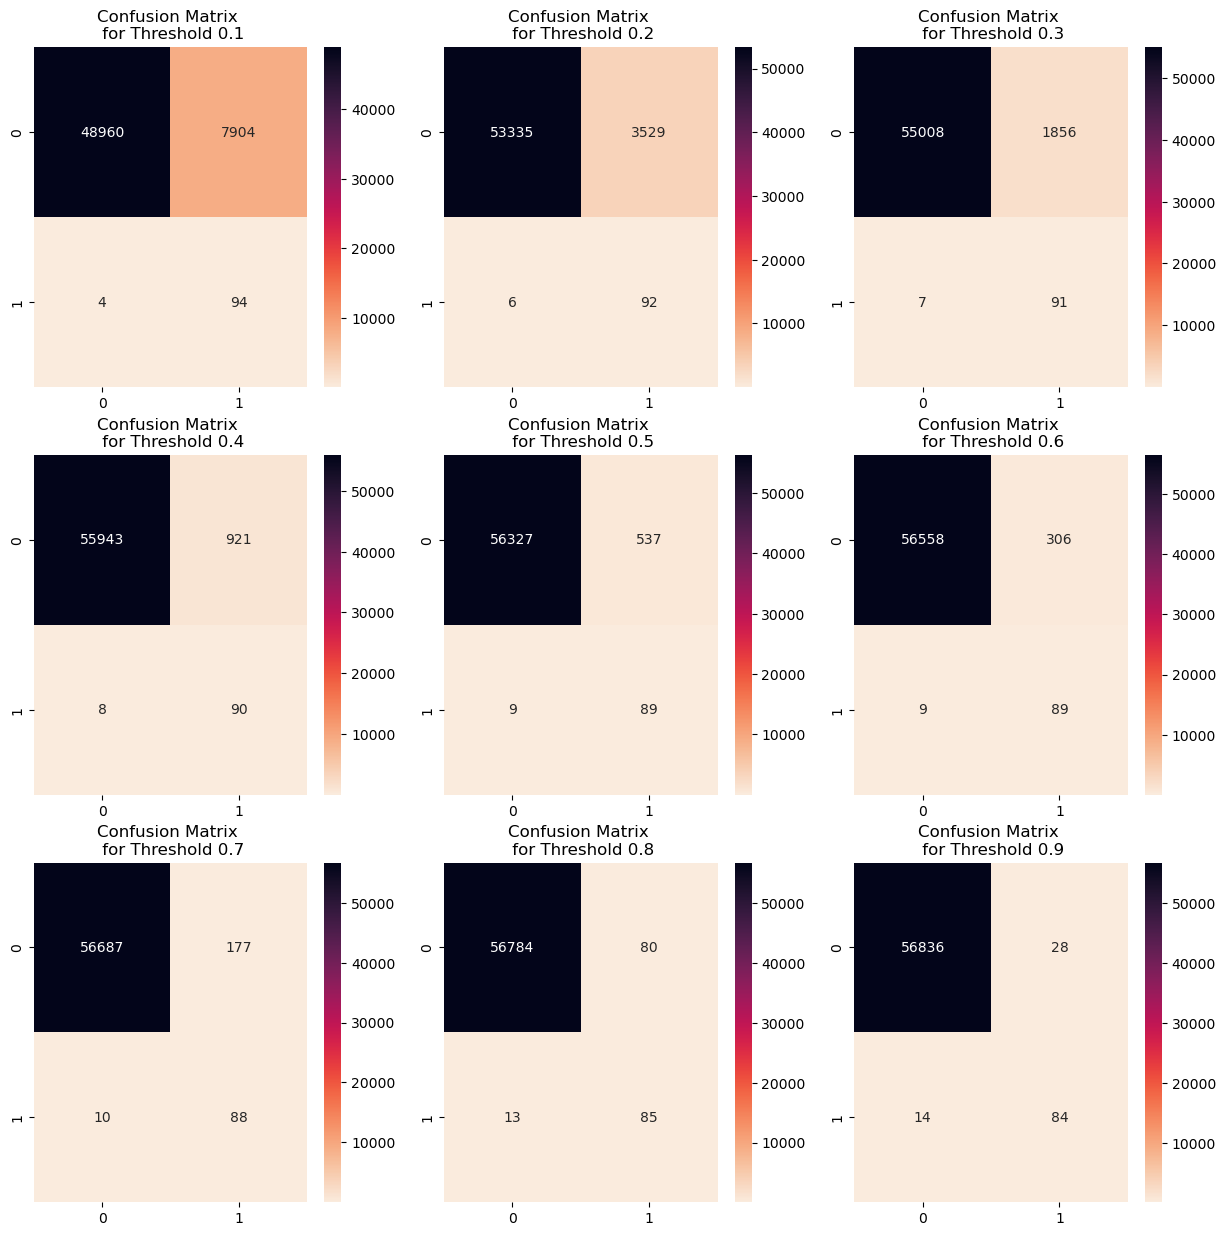

In [59]:
y_pred_proba = final_model.predict_proba(X_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

f, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
sep = 1
for ax, t in zip(axs.reshape(-1), thresholds):
    preds = y_pred_proba[:,1] >= t
    plt.subplot(3,3, sep)
    sep += 1
    
    cm = confusion_matrix(y_test, preds)
    print("------------------------------------------")
    print("Threshold: {}".format(str(t)))
    print("Accuracy Score on full test dataset for final model: {}".format(accuracy_score(y_test, preds)))
    print("Precision Score on full test dataset for final model: {}".format(precision_score(y_test, preds)))
    print("Recall Score on full test dataset for final model: {}".format(recall_score(y_test, preds)))

    sns.heatmap(cm, annot=True, cmap="rocket_r", fmt="d")
    ax.set_title("Confusion Matrix \n for Threshold {}".format(str(t)))
    
plt.savefig('./images/thresholdmatrix.png', dpi=300)